In [ ]:
# Data preprocessing

LANGUAGE = 'pl'
VERBOSE = False # use for analysis of raw data during preprocessing

from preprocess_data import preprocess_pipeline
from analyze_data import get_mean_answers_for_all_stories

dfs, truetemp_data = preprocess_pipeline(LANGUAGE, VERBOSE)

In [2]:
from imp import reload
import analyze_data
reload(analyze_data)

data = analyze_data.load_data()

In [3]:
# Show gender proportions
from tabulate import tabulate

males = []
females = []
total = []
for group, interview_data in data.items():
    total.append(len(interview_data))
    females.append(sum(interviewee['plec'] == 'Kobieta' for interviewee in interview_data))
    males.append(total[-1] - females[-1])

print('{} mężczyzn, {} kobiet, {} łącznie\n'.format(sum(males), sum(females), sum(total)))

print(tabulate(zip(data.keys(), total, males, females), headers=['', 'total', 'males', 'females']))

53 mężczyzn, 160 kobiet, 213 łącznie

        total    males    females
----  -------  -------  ---------
c-t        56       14         42
t-c        51       10         41
t-ch       53       15         38
ch-t       53       14         39


In [3]:
from operator import itemgetter
for group, d in data.items():
    print(group)
    for interviewee in sorted(d, key=itemgetter('total_time')):
        print(interviewee['total_time'],'\t', interviewee)


c-t
62.52 	 {'rok': 1996, 'plec': 'Kobieta', 'wyksztalcenie': 'średnie', 'q1': -2, 'q2': 1, 'total_time': 62.52, 't1': 16.51, 't2': 24.45, 'misc': 21.56}
67.94 	 {'rok': 1996, 'plec': 'Mężczyzna', 'wyksztalcenie': 'wyższe (licencjat, inżynier, magister)', 'q1': -1, 'q2': 1, 'total_time': 67.94, 't1': 24.52, 't2': 24.97, 'misc': 18.45}
75.91 	 {'rok': 1995, 'plec': 'Kobieta', 'wyksztalcenie': 'wyższe (licencjat, inżynier, magister)', 'q1': -1, 'q2': -1, 'total_time': 75.91, 't1': 30.86, 't2': 26.8, 'misc': 18.25}
81.34 	 {'rok': 1982, 'plec': 'Kobieta', 'wyksztalcenie': 'wyższe (licencjat, inżynier, magister)', 'q1': -2, 'q2': -2, 'total_time': 81.34, 't1': 29.52, 't2': 29.46, 'misc': 22.36}
81.97 	 {'rok': 1994, 'plec': 'Mężczyzna', 'wyksztalcenie': 'wyższe (licencjat, inżynier, magister)', 'q1': -2, 'q2': 0, 'total_time': 81.97, 't1': 26.84, 't2': 31.76, 'misc': 23.37}
82.47 	 {'rok': 1994, 'plec': 'Kobieta', 'wyksztalcenie': 'wyższe (licencjat, inżynier, magister)', 'q1': -2, 'q2': 0

In [4]:
import matplotlib.pyplot as plt
import numpy as np

for group, d in data.items():
    print(group)
    x = [interviewee['q1'] for interviewee in d]
    y = [interviewee['q2'] for interviewee in d]
    
    fit = np.polyfit(x,y,1)
    fun = np.poly1d(fit)
    
    plt.plot(x, y, 'yo', x, fun(x), '--k')
    plt.show()
    plt.clf()

c-t


<Figure size 640x480 with 1 Axes>

t-c


<Figure size 640x480 with 1 Axes>

t-ch


<Figure size 640x480 with 1 Axes>

ch-t


<Figure size 640x480 with 1 Axes>

In [5]:
from tabulate import tabulate

def position_of_truetemp(group):
    stories = group.split('-')
    pos = stories.index('t')
    return pos, stories[(pos+1)%2]

labels = ['group', 'q1', 'std1', 'q2', 'std2']
mean_data = []

for group, d in data.items():
    q1 = [interviewee['q1'] for interviewee in d]
    q2 = [interviewee['q2'] for interviewee in d]
    
    mean_data.append([group, np.mean(q1), np.std(q1), np.mean(q2), np.std(q2)])


print(tabulate(mean_data, labels))

labels.append('truetemp')
for d in mean_data:
    pos, _ = position_of_truetemp(d[0])
    truetemp = d[1+pos*2]
    d.append(truetemp)
    
mean_data = sorted(mean_data, key=itemgetter(-1))
print(tabulate(mean_data, labels))

group           q1      std1          q2      std2
-------  ---------  --------  ----------  --------
c-t      -0.910714  1.00493    0.0892857  0.96874
t-c       0.254902  1.13489   -0.901961   1.05263
t-ch      0.377358  1.05018    1.03774    0.776112
ch-t      0.981132  0.764558   0.0943396  1.12038
group           q1      std1          q2      std2    truetemp
-------  ---------  --------  ----------  --------  ----------
c-t      -0.910714  1.00493    0.0892857  0.96874    0.0892857
ch-t      0.981132  0.764558   0.0943396  1.12038    0.0943396
t-c       0.254902  1.13489   -0.901961   1.05263    0.254902
t-ch      0.377358  1.05018    1.03774    0.776112   0.377358


In [6]:
from collections import defaultdict

truetemp_pos_data = defaultdict(lambda: [])
truetemp_data = defaultdict(lambda: [])
for group, d in data.items():
    truetemp_pos, other = position_of_truetemp(group)
    answers = [interviewee['q{}'.format(truetemp_pos+1)] for interviewee in d]
    if truetemp_pos:
        label = other
    else:
        label = 'none'
    truetemp_pos_data[label] += answers
    truetemp_data[group] += answers

In [7]:
from scipy.stats import f_oneway, ttest_ind

def show_truetemp_answers_stats(data):
    rob = data.values()
    print('Wszystkie oceny truetempa: {}\n'.format(sum(len(list(group_data)) for group_data in data.values())))
    headers = ['group', 'answers']
    print(tabulate([[group, len(list(answers))] for group, answers in data.items()], headers=headers), '\n')

print('Podsumowanie po grupach')
show_truetemp_answers_stats(truetemp_data)
print('Test dzielony po wszystkich grupach')
print('{}, {}, {}, {}'.format(*list(truetemp_data.keys())))
test_data = tuple(truetemp_data.values())
print(f_oneway(*test_data), '\n')

# print('Podsumowanie po kolejności truetempa')
# show_truetemp_answers_stats(truetemp_pos_data)
print('Test dzielony po kolejności truetempa i poprzedzającej historyjce')
print('c-t, t-*, ch-t')
test_data = tuple(truetemp_pos_data.values())
print(f_oneway(*test_data), '\n')

print('Test dzielony tylko po kolejności truetempa')
print('*-t, t-*')
test_data = list(truetemp_data['c-t']) + list(truetemp_data['ch-t']), list(truetemp_data['t-c']) + list(truetemp_data['t-ch'])
print(f_oneway(*test_data))
print(ttest_ind(*test_data), '\n')

print('Test wpływu na truetempa')
print('c-t, ch-t')
test_data = truetemp_data['c-t'], truetemp_data['ch-t']
print(f_oneway(*test_data))
print(ttest_ind(*test_data))

Podsumowanie po grupach
Wszystkie oceny truetempa: 213

group      answers
-------  ---------
c-t             56
t-c             51
t-ch            53
ch-t            53 

Test dzielony po wszystkich grupach
c-t, t-c, t-ch, ch-t
F_onewayResult(statistic=0.8874489433280394, pvalue=0.4484733591798875) 

Test dzielony po kolejności truetempa i poprzedzającej historyjce
c-t, t-*, ch-t
F_onewayResult(statistic=1.1674181789420581, pvalue=0.3131803517029923) 

Test dzielony tylko po kolejności truetempa
*-t, t-*
F_onewayResult(statistic=2.3453455398561225, pvalue=0.12715559278271607)
Ttest_indResult(statistic=-1.531452101717883, pvalue=0.12715559278271515) 

Test wpływu na truetempa
c-t, ch-t
F_onewayResult(statistic=0.0006249283733445547, pvalue=0.9801026684557157)
Ttest_indResult(statistic=-0.024998567425845452, pvalue=0.98010266845559)


preceding      truetemp mean    truetemp std
-----------  ---------------  --------------
c                  0.0892857        0.938457
none               0.317308         1.19739
ch                 0.0943396        1.25525


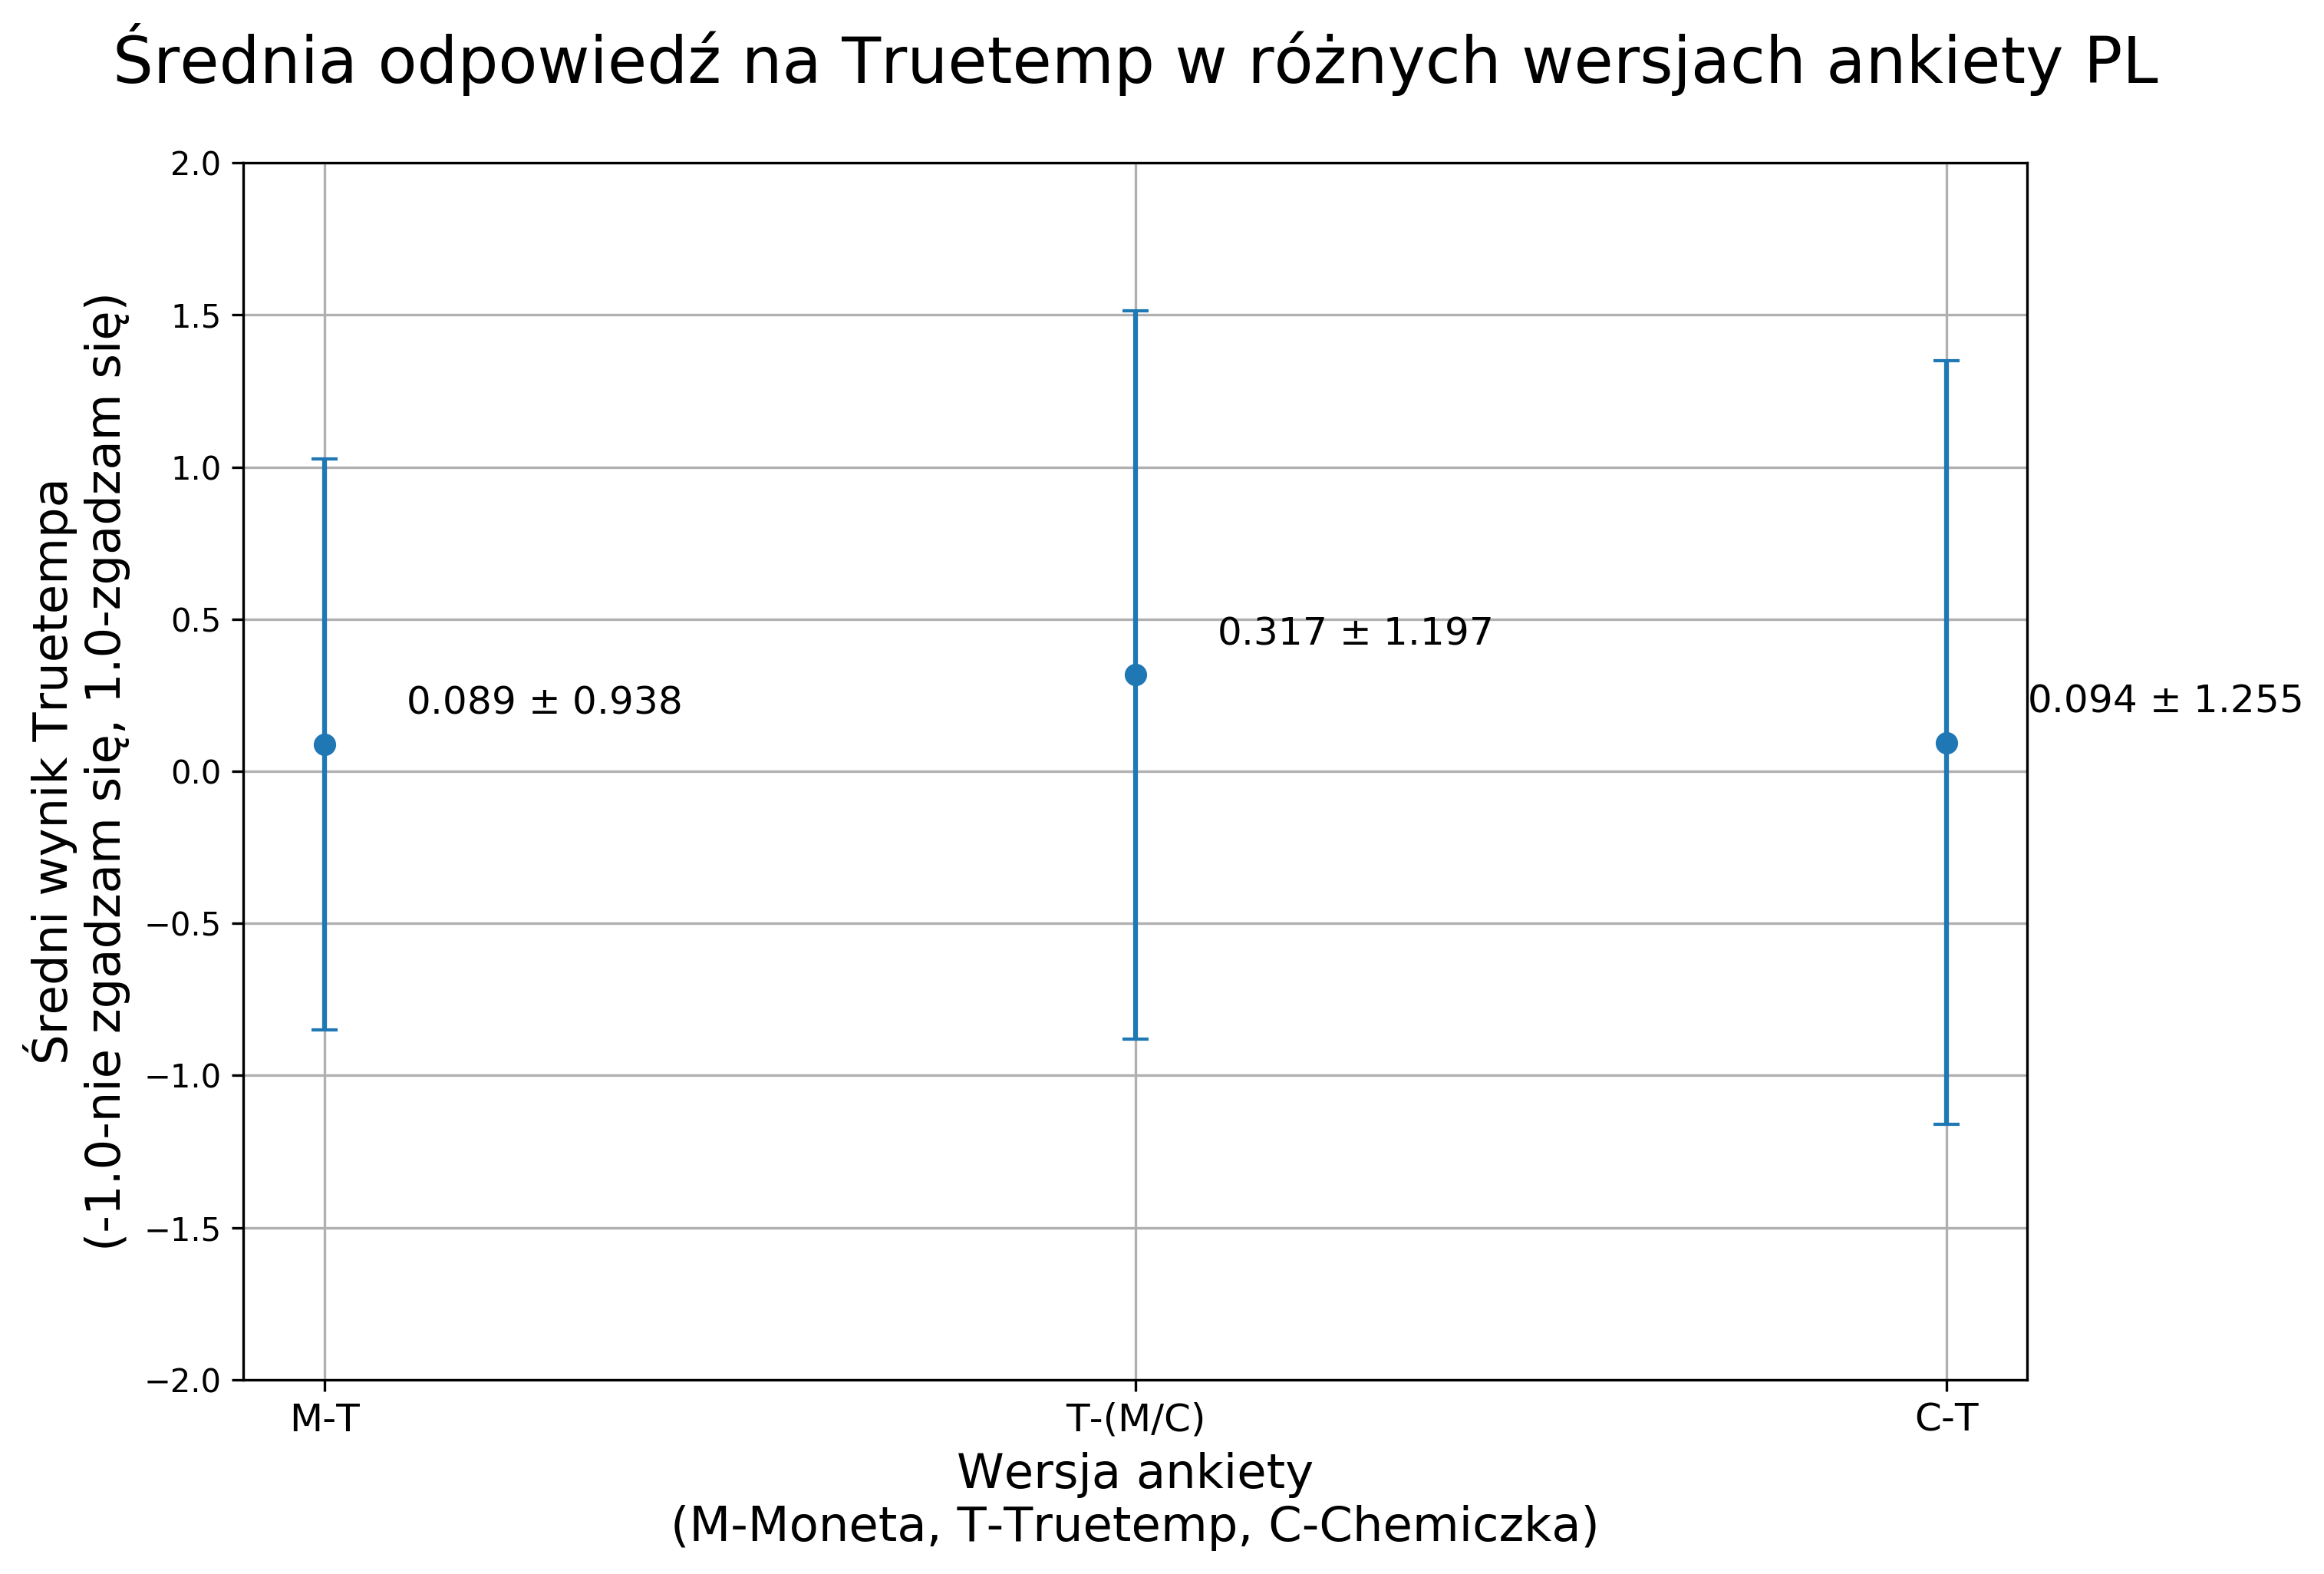

In [8]:
from visualize_data import plot_truetemp_dependence_on_preceding_story

plot_truetemp_dependence_on_preceding_story(truetemp_pos_data, 'mean_truetemp_pl.png')